## Ep3.1

In [ ]:
#EP3.1
import os
import numpy as np
import cv2
from skimage import io, color
from skimage.filters import threshold_otsu
from pillow_heif import register_heif_opener

# Registrar suporte para arquivos HEIC
register_heif_opener()

image_folder = "augmented_fotos"
output_folder = "Novo"

os.makedirs(output_folder, exist_ok=True)

# Função para ler imagens (suporta .heic)
def read_image(file_path):
    if file_path.lower().endswith(".heic"):
        from PIL import Image
        image = Image.open(file_path)
        return np.array(image)
    else:
        return io.imread(file_path)

def segment_image(image):
    if image.ndim == 3:  
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
    
    thresh = threshold_otsu(gray_image)
    binary_mask = gray_image <= thresh  # Invertido para atender à sua necessidade
    return binary_mask.astype(np.uint8) 

for file_name in os.listdir(image_folder):
    file_path = os.path.join(image_folder, file_name)
    if os.path.isfile(file_path):
        try:
            
            image = read_image(file_path)
            binary_image = segment_image(image)
            
            output_path = os.path.join(output_folder, f"binary_{file_name}.png")
            cv2.imwrite(output_path, (binary_image * 255).astype(np.uint8))  
            print(f"Segmentação concluída para: {file_name}")
        except Exception as e:
            print(f"Erro ao processar {file_name}: {e}")

print(f"Processamento concluído. Imagens segmentadas salvas em: {output_folder}")


# EP3.2
import os
import numpy as np
import cv2
from skimage import io, measure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Diretório com as imagens binárias
binary_images_folder = "segmented_images"

# Classes de objetos
classes = ["caneca", "tenis", "oculos", "relogio"]

# Tamanho padrão para redimensionar as RoIs
roi_size = (64, 64)

def extract_class_from_filename(filename):
    """Identifica a classe com base no nome do arquivo."""
    for obj_class in classes:
        if obj_class.lower() in filename.lower():
            return obj_class
    return None

def process_roi(image, target_size):
    """Processa a região de interesse (RoI) a partir da imagem binária."""
    labeled_image = measure.label(image)
    regions = measure.regionprops(labeled_image)

    if not regions:
        return np.zeros(target_size)  # Retorna uma matriz vazia se nenhuma região for encontrada

    largest_region = max(regions, key=lambda r: r.area)  # Seleciona a maior região
    minr, minc, maxr, maxc = largest_region.bbox

    roi = image[minr:maxr, minc:maxc]
    resized_roi = cv2.resize(roi, target_size, interpolation=cv2.INTER_AREA)
    return resized_roi

def load_binary_images(folder):
    """Carrega as imagens binárias e extrai as RoIs e suas classes."""
    data = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if os.path.isfile(img_path):
            obj_class = extract_class_from_filename(img_name)
            if obj_class:
                img = io.imread(img_path, as_gray=True)
                img = (img > 0.5).astype(np.uint8)  # Binariza a imagem
                roi = process_roi(img, roi_size)
                data.append(roi)
                labels.append(obj_class)
    return np.array(data), np.array(labels)

# Carregar imagens e classes
rois, labels = load_binary_images(binary_images_folder)
print(f"Total de imagens carregadas: {len(rois)}")
print(f"Shape das RoIs: {rois.shape}")
print("Distribuição das classes:", Counter(labels))

# Flatten das RoIs para uso no PCA
X = rois.reshape(len(rois), -1)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=10)  # Mantém 10 componentes principais
X_pca = pca.fit_transform(X)

# Salvar vetores de características em um arquivo CSV
feature_vectors = pd.DataFrame(X_pca)
feature_vectors['class'] = labels
feature_vectors.to_csv("feature_vectors.csv", index=False)
print("Vetores de características salvos em 'feature_vectors.csv'.")

# Plotar a variância explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.show()

# Visualizar autovetores do PCA
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca.components_[i].reshape(roi_size), cmap='gray')
    plt.title(f'Componente {i + 1}')
    plt.axis('off')
plt.suptitle('Autovetores do PCA')
plt.tight_layout()
plt.show()

# Visualização 2D das duas primeiras componentes principais
plt.figure(figsize=(8, 6))
for obj_class in np.unique(labels):
    indices = labels == obj_class
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=obj_class)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Visualização 2D das Classes')
plt.legend()
plt.tight_layout()
plt.show()

# Divisão dos dados em treino e teste, mantendo a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42, stratify=labels)

# Treinar o classificador SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = svm.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação:")
report = classification_report(y_test, y_pred, target_names=np.unique(labels))
print(report)

# Salvar o relatório em arquivo
with open("classification_report.txt", "w") as f:
    f.write(report)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=np.unique(labels))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Reais')
plt.tight_layout()
plt.savefig("confusion_matrix.png")  # Salvar a matriz de confusão como imagem
plt.show()

# Cálculo de acurácia média
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

# Comparação com diferentes kernels do SVM
kernels = ['linear', 'rbf', 'poly']
results = {}
for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train, y_train)
    y_pred_kernel = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred_kernel)
    results[kernel] = acc
    print(f"Kernel: {kernel}, Acurácia: {acc:.2f}")

# Salvar resultados comparativos em CSV
results_df = pd.DataFrame(list(results.items()), columns=['Kernel', 'Acurácia'])
results_df.to_csv("svm_kernel_comparison.csv", index=False)
print("Resultados comparativos salvos em 'svm_kernel_comparison.csv'.")


Erro ao processar Downloads - Atalho.lnk: Could not find a backend to open `augmented_fotos\Downloads - Atalho.lnk`` with iomode `r`.
Segmentação concluída para: exp_caneca1-dia-in-fundo1.jpg
Segmentação concluída para: exp_caneca1-dia-in-fundo2.jpg
Segmentação concluída para: exp_caneca1-dia-in-fundo3.jpg
Segmentação concluída para: exp_caneca1-dia-out-fundo1.jpg
Segmentação concluída para: exp_caneca1-dia-out-fundo2.jpg
Segmentação concluída para: exp_caneca1-dia-out-fundo3.jpg
Segmentação concluída para: exp_caneca1-noite-in-fundo1.jpg
Segmentação concluída para: exp_caneca1-noite-in-fundo2.jpg
Segmentação concluída para: exp_caneca1-noite-in-fundo3.jpg
Segmentação concluída para: exp_caneca1-noite-out-fundo1.jpg
Segmentação concluída para: exp_caneca1-noite-out-fundo2.jpg
Segmentação concluída para: exp_caneca1-noite-out-fundo3.jpg
Segmentação concluída para: exp_caneca2-dia-in-fundo1.jpg
Segmentação concluída para: exp_caneca2-dia-in-fundo2.jpg
Segmentação concluída para: exp_cane

## Ep3.2

Total de imagens carregadas: 828
Shape das RoIs: (828, 64, 64)
Distribuição das classes: Counter({'caneca': 207, 'oculos': 207, 'relogio': 207, 'tenis': 207})
Vetores de características salvos em 'feature_vectors.csv'.


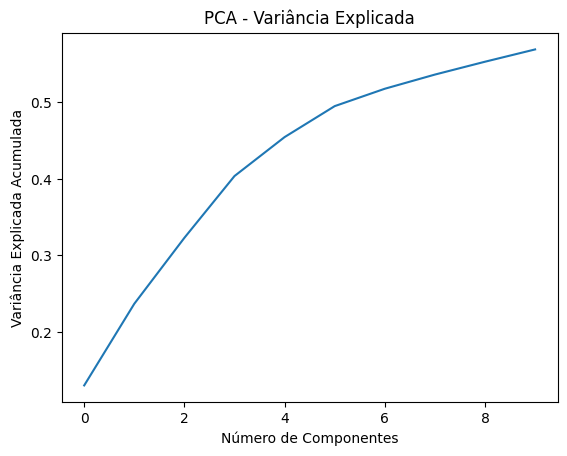

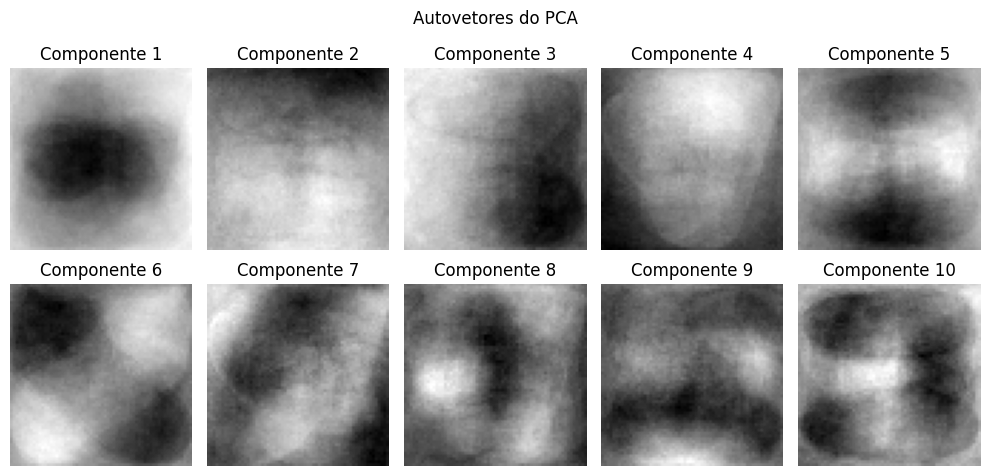

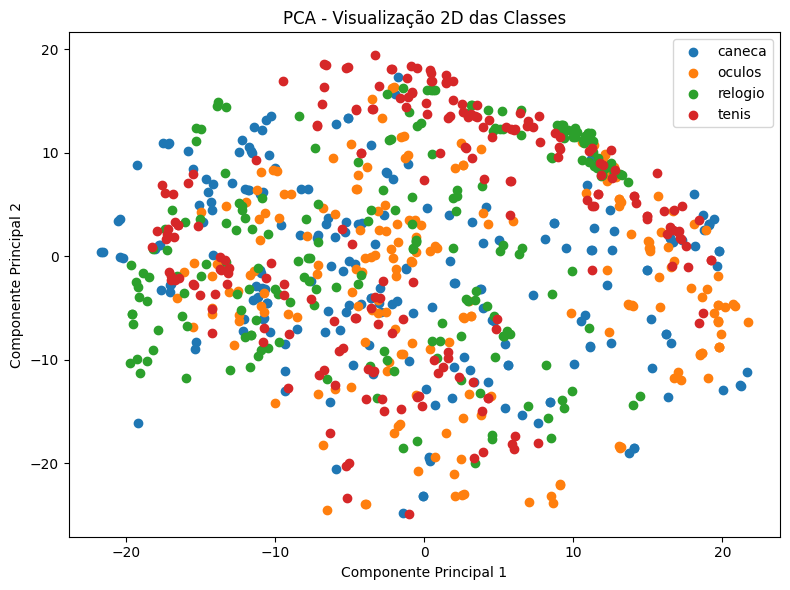

Relatório de Classificação:
              precision    recall  f1-score   support

      caneca       0.40      0.40      0.40        42
      oculos       0.49      0.44      0.46        41
     relogio       0.51      0.57      0.54        42
       tenis       0.62      0.59      0.60        41

    accuracy                           0.50       166
   macro avg       0.50      0.50      0.50       166
weighted avg       0.50      0.50      0.50       166



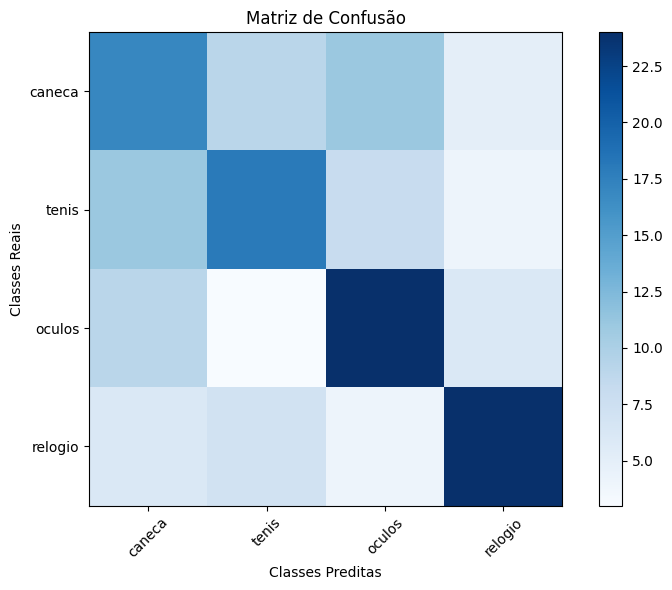

Acurácia: 0.50
Kernel: linear, Acurácia: 0.50
Kernel: rbf, Acurácia: 0.78
Kernel: poly, Acurácia: 0.73
Resultados comparativos salvos em 'svm_kernel_comparison.csv'.


In [4]:
import os
import numpy as np
import cv2
from skimage import io, measure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Diretório com as imagens binárias
binary_images_folder = "segmented_images"

# Classes de objetos
classes = ["caneca", "tenis", "oculos", "relogio"]

# Tamanho padrão para redimensionar as RoIs
roi_size = (64, 64)

def extract_class_from_filename(filename):
    """Identifica a classe com base no nome do arquivo."""
    for obj_class in classes:
        if obj_class.lower() in filename.lower():
            return obj_class
    return None

def process_roi(image, target_size):
    """Processa a região de interesse (RoI) a partir da imagem binária."""
    labeled_image = measure.label(image)
    regions = measure.regionprops(labeled_image)

    if not regions:
        return np.zeros(target_size)  # Retorna uma matriz vazia se nenhuma região for encontrada

    largest_region = max(regions, key=lambda r: r.area)  # Seleciona a maior região
    minr, minc, maxr, maxc = largest_region.bbox

    roi = image[minr:maxr, minc:maxc]
    resized_roi = cv2.resize(roi, target_size, interpolation=cv2.INTER_AREA)
    return resized_roi

def load_binary_images(folder):
    """Carrega as imagens binárias e extrai as RoIs e suas classes."""
    data = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if os.path.isfile(img_path):
            obj_class = extract_class_from_filename(img_name)
            if obj_class:
                img = io.imread(img_path, as_gray=True)
                img = (img > 0.5).astype(np.uint8)  # Binariza a imagem
                roi = process_roi(img, roi_size)
                data.append(roi)
                labels.append(obj_class)
    return np.array(data), np.array(labels)

# Carregar imagens e classes
rois, labels = load_binary_images(binary_images_folder)
print(f"Total de imagens carregadas: {len(rois)}")
print(f"Shape das RoIs: {rois.shape}")
print("Distribuição das classes:", Counter(labels))

# Flatten das RoIs para uso no PCA
X = rois.reshape(len(rois), -1)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=10)  # Mantém 10 componentes principais
X_pca = pca.fit_transform(X)

# Salvar vetores de características em um arquivo CSV
feature_vectors = pd.DataFrame(X_pca)
feature_vectors['class'] = labels
feature_vectors.to_csv("feature_vectors.csv", index=False)
print("Vetores de características salvos em 'feature_vectors.csv'.")

# Plotar a variância explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.show()

# Visualizar autovetores do PCA
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca.components_[i].reshape(roi_size), cmap='gray')
    plt.title(f'Componente {i + 1}')
    plt.axis('off')
plt.suptitle('Autovetores do PCA')
plt.tight_layout()
plt.show()

# Visualização 2D das duas primeiras componentes principais
plt.figure(figsize=(8, 6))
for obj_class in np.unique(labels):
    indices = labels == obj_class
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=obj_class)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Visualização 2D das Classes')
plt.legend()
plt.tight_layout()
plt.show()

# Divisão dos dados em treino e teste, mantendo a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42, stratify=labels)

# Treinar o classificador SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = svm.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação:")
report = classification_report(y_test, y_pred, target_names=np.unique(labels))
print(report)

# Salvar o relatório em arquivo
with open("classification_report.txt", "w") as f:
    f.write(report)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=np.unique(labels))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Reais')
plt.tight_layout()
plt.savefig("confusion_matrix.png")  # Salvar a matriz de confusão como imagem
plt.show()

# Cálculo de acurácia média
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

# Comparação com diferentes kernels do SVM
kernels = ['linear', 'rbf', 'poly']
results = {}
for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train, y_train)
    y_pred_kernel = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred_kernel)
    results[kernel] = acc
    print(f"Kernel: {kernel}, Acurácia: {acc:.2f}")

# Salvar resultados comparativos em CSV
results_df = pd.DataFrame(list(results.items()), columns=['Kernel', 'Acurácia'])
results_df.to_csv("svm_kernel_comparison.csv", index=False)
print("Resultados comparativos salvos em 'svm_kernel_comparison.csv'.")
